# Quora Question Pair Similiarity

### Business Problem

Where else but Quora can a physicist help a chef with a math problem and get cooking tips in return? Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

### Goal

The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree.

As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

In this notebook we will use the dataset from Kaggle and perform the __Exploratory Data Analysis__

### Dataset

Data fields
- __id__ - the id of a training set question pair
- __qid1, qid2__ - unique ids of each question (only available in train.csv)
- __question1, question2__ - the full text of each question
- __is_duplicate__ - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [27]:
# Lets import all libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.io as pio
%matplotlib inline

warnings.filterwarnings('ignore')

Let's check the available files from the competetion and the sizes

In [2]:
for file in os.listdir('./data'):
    print('Filename: {0} --> {1}'.format(file.ljust(30).rstrip(),
                                       str(round(os.path.getsize('./data/'+file)/1000000,2))+'MB'))

Filename: test.csv --> 314.02MB
Filename: train.csv --> 63.4MB


In [3]:
# Read the training data
questions_original = pd.read_csv('./data/train.csv')
print('Number of Examples in the training set :',questions_original.shape[0])

Number of Examples in the training set : 404290


In [4]:
# Example rows from the given training set
questions_original.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
questions_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


#### Distribution of observations among the output classes

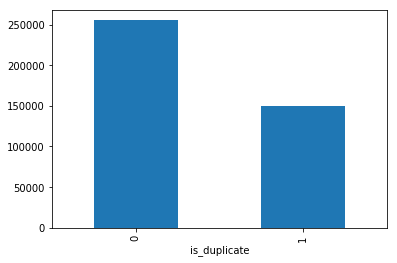

In [6]:
questions_original.groupby('is_duplicate')['id'].count().plot.bar()

In [7]:
# is_duplicate == 0
print('Question Pairs that are not similar: {} %'.format(100-round(questions_original['is_duplicate'].mean()*100,2)))

Question Pairs that are not similar: 63.08 %


In [8]:
# is_duplicate == 1
print('Question Pairs that are similar: {} %'.format(round(questions_original['is_duplicate'].mean()*100,2)))

Question Pairs that are similar: 36.92 %


Number of unique questions

In [9]:
qids_series = pd.Series(questions_original.qid1.to_list() +
                        questions_original.qid2.to_list())
unique_questions = len(np.unique(qids_series))
print('Total Number of Unique Questions: {}'.format(unique_questions))

Total Number of Unique Questions: 537933


Number of questions which occur more than once

In [10]:
ques_morethan_once = np.sum(qids_series.value_counts() > 1)
print('Questions appearing more than once: {}'.format(ques_morethan_once))

Questions appearing more than once: 111780


In [11]:
print('Highest occurance of a single question: {}'.format(max(qids_series.value_counts())))

Highest occurance of a single question: 157


#### Plot the frequency of the times the questions appear

Text(0, 0.5, 'Number of Questions')

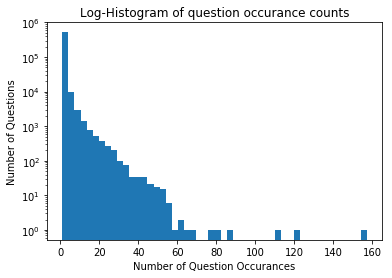

In [12]:
plt.hist(qids_series.value_counts(), bins = 50)
# nonposy: [ 'mask' | 'clip' ] non-positive values in y can be masked as invalid, or clipped to a very small positive number
plt.yscale('log',nonposy = 'clip') 
plt.title('Log-Histogram of question occurance counts')
plt.xlabel('Number of Question Occurances')
plt.ylabel('Number of Questions')

### Check NaN values

In [13]:
nan_rows = questions_original[questions_original.isnull().any(axis = 1)] 
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


We observe 3 records with NaN Values , either in Question 1 / Question 2

In [14]:
# Fill the null values with ' '
questions_original.fillna(' ',inplace=True)
nan_rows = questions_original[questions_original.isnull().any(axis = 1)] 
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


### Feature Extraction

Now, lets featurize or enrich the dataset to have some useful features

- __freq_qid1__ = Frequency of qid1's
- __freq_qid2__ = Frequency of qid2's
- __q1len__ = Length of q1
- __q2len__ = Length of q2
- __q1_n_words__ = Number of words in Question 1
- __q2_n_words__ = Number of words in Question 2
- __word_Common__ = (Number of common unique words in Question 1 and Question 2)
- __word_Total__ =(Total num of words in Question 1 + Total num of words in Question 2)
- __word_share__ = (word_common)/(word_Total)
- __freq_q1+freq_q2__ = sum total of frequency of qid1 and qid2
- __freq_q1-freq_q2__ = absolute difference of frequency of qid1 and qid2



In [15]:
# Check if file is already present with featurization, if not recreate it 
if os.path.isfile('./data/question_feature_extracted.csv'):
    questions_featurized = pd.read_csv('./data/question_feature_extracted.csv')
else:
    questions_original['freq_qid1'] = questions_original.groupby('qid1')['qid1'].transform('count')
    questions_original['freq_qid2'] = questions_original.groupby('qid2')['qid2'].transform('count')
    questions_original['q1_len'] = questions_original.question1.str.len()
    questions_original['q2_len'] = questions_original.question2.str.len()
    questions_original['q1_n_words'] = questions_original.question1.apply(lambda question : len(question.split(' ')))
    questions_original['q2_n_words'] = questions_original.question2.apply(lambda question : len(question.split(' ')))
    
    def get_unique_words_from_qs(row):
        unique_words_from_q1 = set(map(lambda word : word.lower().strip(), row.question1.split(' ')))
        unique_words_from_q2 = set(map(lambda word : word.lower().strip(), row.question2.split(' ')))
        return unique_words_from_q1,unique_words_from_q2
    
    def get_common_words(row):
        unique_words_from_q1,unique_words_from_q2 = get_unique_words_from_qs(row)
        return 1 * len(unique_words_from_q1 & unique_words_from_q2)
    
    questions_original['words_common'] = questions_original.apply(get_common_words,axis=1)
    
    def get_total_common_unique_words(row):
        unique_words_from_q1,unique_words_from_q2 = get_unique_words_from_qs(row)
        return 1*(len(unique_words_from_q1) + len(unique_words_from_q2))
    
    questions_original['total_unique_words'] = questions_original.apply(get_total_common_unique_words,axis = 1)
    questions_original['words_shared_bw_qs'] = questions_original['words_common']/questions_original['total_unique_words']
    questions_original['freq_q1+q2'] = questions_original['freq_qid1']+questions_original['freq_qid2']
    questions_original['freq_q1-q2'] = abs(questions_original['freq_qid1']-questions_original['freq_qid2'])
    
    questions_original.to_csv('./data/question_feature_extracted.csv')

In [16]:
questions_original.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1_len,q2_len,q1_n_words,q2_n_words,words_common,total_unique_words,words_shared_bw_qs,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


#### words_shared_bw_qs 
Now lets see if the new __words_shared_bw_qs__ features can help us easily classify between the classes if we plot them

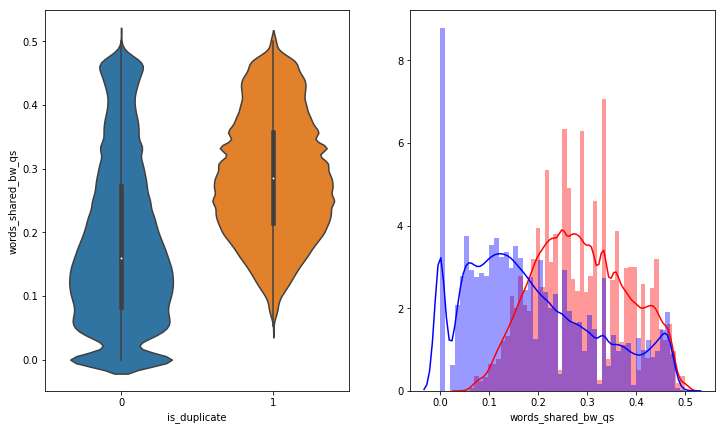

In [20]:
plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='words_shared_bw_qs',data=questions_original)

plt.subplot(1,2,2)
crit_is_duplicate = questions_original.is_duplicate==1.0
crit_no_duplicate = questions_original.is_duplicate==0
sns.distplot(questions_original[crit_is_duplicate].words_shared_bw_qs, label = '1', color = 'red')
sns.distplot(questions_original[crit_no_duplicate].words_shared_bw_qs, label = '0', color = 'blue')

plt.show()

- As it can be seen there is a visible overlap between both the classes, on the far right side of the distribution plot, which means that there are a considerable number of classes which are both duplicate and non duplicate.

- It can also be seen that once the __words_shared_bw_qs__ value increases, there is higher probability that the question is a duplicate   ( Can be seen from the peak of the red plot )

#### words_common 
Lets plot the same for the feature __words_common__

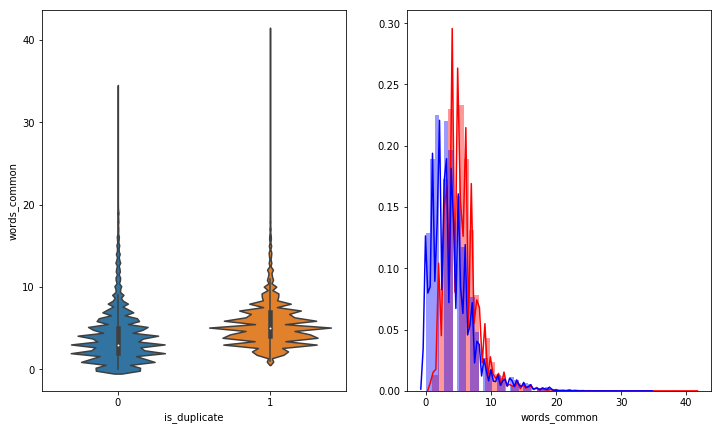

In [22]:
plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='words_common',data=questions_original)

plt.subplot(1,2,2)
crit_is_duplicate = questions_original.is_duplicate==1.0
crit_no_duplicate = questions_original.is_duplicate==0
sns.distplot(questions_original[crit_is_duplicate].words_common, label = '1', color = 'red')
sns.distplot(questions_original[crit_no_duplicate].words_common, label = '0', color = 'blue')

plt.show()

This has even more overlap can the classes cannot be easily distinguished from each other

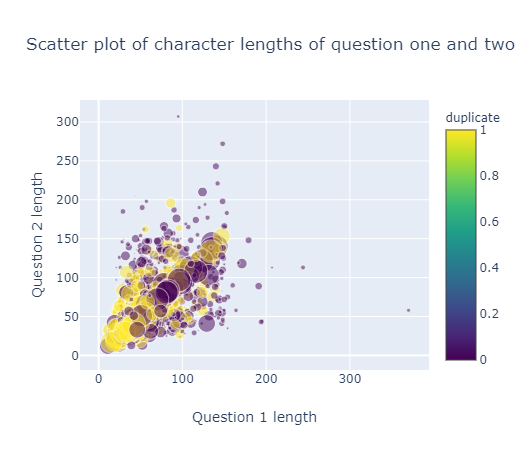

In [38]:
questions_subsampled = questions_original[0:2000]

fig = go.Figure()
fig.add_trace(
            go.Scatter(
                x= questions_subsampled['q1_len'].values,
                y= questions_subsampled['q2_len'].values,
                mode = 'markers',
                marker = dict(
                            size = questions_subsampled['words_shared_bw_qs'].values*50
                    ,
                            color = questions_subsampled['is_duplicate'].values,
                            colorscale = 'Viridis',
                            showscale =True,
                            opacity = 0.5,
                            colorbar = dict(title='duplicate')
                                ),
                text = np.round(questions_subsampled['words_shared_bw_qs'].values,decimals=2)
                    )
                )

fig.update_layout( title='Scatter plot of character lengths of question one and two',
                      hovermode= 'closest',
                     xaxis_title_text = 'Question 1 length',
                        yaxis_title_text = 'Question 2 length'
                    )
pio.show(fig)

In the above plot, the color signifies the duplicate status or not and the size indicates the words_shared_bw_qs